# <Center> Homework 5: Classification </center>

This assignment is about building classification models with labeled data. We will work with a dataset with human generated content and ChatGPT generated content. The `text` column contains documents and the `label` column gives the label of each document. We will build classifers to detect AI generated content. 


## Q1 Classification

- Define a function `create_model(x_train, y_train, x_test, y_test, model_type='svm', stop_words='english', min_df = 1, print_result = True, algorithm_para=1.0`), where

    - `x_train`: is a list of documents for training
    - `y_train`: is the ground-truth labels of training documents
    - `x_test`: is a list of documents for test
    - `y_test`: is the ground-truth labels of test documents
    - `model_type`: two options: `nb` (Multinomial Naive Bayes) or `svm` (Linear SVM)
    - `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
    - `min_df`: only word with document frequency above this threshold can be included. The default is 1. 
    - `print_result`: controls whether to show classification report or plots. The default is True.
    - `algorithm_para`: hyperparameter of algorithms, refers to C in SVM and alpha in NB. Both C and alpha have default values of 1.0. Please check sklearn documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


- This function does the following:
    - Fit a `TfidfVectorizer` using `x_train` with options `stop_words, min_df` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
    - Build `linear SVM` or `Multinomial Naive Bayes` model as specified by `model_type` with `algorithm_para` setting. Train the model using the extracted features and `y_train`. 
    - Transform `x_test` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
    - Predict the labels for `x_test`. If `print_result` is True, print the classification report.
    - Calculate the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. If `print_result` is True, plot the ROC and PRC curves. **Hint**: 
        - `sklearn.svm.LinearSVC` does not provide `predict_proba` function. 
        - Instead, you can use its `decision_function` (see <a href = "https://stackoverflow.com/questions/59227176/how-to-plot-roc-and-calculate-auc-for-binary-classifier-with-no-probabilities-s">some reference code</a>) 
        - Another option is to use `sklearn.svm.SVC` with `kernel='linear' and probability=False` (see <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html"> reference</a>)
    - Return the AUC and PRC scores.

    
- Test your function with following cases, with or without your customized tokenizer. Explain your findings. 
    - model_type='svm', stop_words = 'english', min_df = 1
    - model_type='nb', stop_words = 'english', min_df = 1

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
#load data
data=pd.read_csv("detect.csv")

# separate into train and test
x_train, x_test, y_train, y_test = train_test_split(\
                data["text"], data["label"], test_size=0.3, random_state=0)

In [2]:
def show_plots(params):
    plt.figure().set_figwidth(5);
    plt.plot(params["x"], params["y"], color='darkorange', lw=2);
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    
    if params["curve"] == 'auc':
        plt.xlabel('False Positive Rate');
        plt.ylabel('True Positive Rate');
        
    if params["curve"] == 'prc':
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        
    plt.title(params["title"]);
    plt.show();

In [3]:
def create_model(x_train, y_train, x_test, y_test,
                 model_type="svm", min_df = 1,stop_words=None, 
                 print_result = True, algorithm_para=1.0):

    # initialize the TfidfVectorizer without any parameters
    vec = TfidfVectorizer(stop_words=stop_words, min_df=min_df) 

    # choose classification model and add hyperparams
    if model_type == 'svm':
        model, model_name = svm.LinearSVC(C=algorithm_para), 'Linear SVM Model'

    elif model_type == 'nb':
        model, model_name = MultinomialNB(alpha=algorithm_para), 'Naive-Bayes Model'

    else:
        print('Please choose Multinomial Naive-Bayes (nb) or Linear SVM (svm) as the model type.')
    
    # fit vectorizer using x_train and vectorize training data
    x_train = vec.fit_transform(x_train)
    x_test = vec.transform(x_test)
    # fit classifier model with training data
    model.fit(x_train, y_train)
    
    if model_type == 'svm':
        # predict test set output and get probability of guessing each class
        bin_preds = model.predict(x_test)
        pred_scores = model.decision_function(x_test)
        
    elif model_type == 'nb':
        # get classification probs and choose "1" class
        pred_scores = model.predict_proba(x_test)[:,1]
        # convert to binary output based on confidence score
        bin_preds = np.where(pred_scores>0.5, 1, 0)
    
    # get ROC curve using tpr/fpr and calculate AUC score
    fpr, tpr, _ = roc_curve(y_test, pred_scores)
    auc_score = roc_auc_score(y_test, pred_scores)
    
    # get PRC curve using precision/recall and calculate PRC score
    precision, recall, _ = precision_recall_curve(y_test, pred_scores)
    prc_score = auc(recall, precision)
    
    if print_result: 
        # print curve scores
        print(' AUC:{:.2%}\n'.format(auc_score),'PRC:{:.2%}\n'.format(prc_score))
        # print classification report
        print( classification_report(y_test, bin_preds, target_names=['0','1']) )
        # show curve plots
        show_plots({'x':fpr, 
                    'y':tpr, 
                    'curve':'auc', 
                    'title': 'AUC of '+ model_name})
        show_plots({'x':recall, 
                    'y':precision, 
                    'curve':'prc', 
                    'title': 'PRC of '+ model_name})
    
    return auc_score, prc_score

### Multinomial Naive-Bayes

Using Naive-Bayes as a classifier, specifying stopwords reduced precision for both classes. Recall decreased for class "0" and increased for class "1". This means total prediction accuracy was reduced, but the classifier's sensitivity to items in class "1" increased. This indicates removing stopwords will result in more false positive classifications overall, but slightly more true positives for "1". Since recall for "0" decreased, this indicates removing stopwords also means some information that is relevant to classifying "0" features gets dropped. Overall, there is a max. change of |1| % for the precision and recall of both classes, indicating a need for more feature engineering/other techniques to improve model performance. 

 AUC:90.08%
 PRC:90.39%

              precision    recall  f1-score   support

           0       0.69      0.94      0.80      2968
           1       0.91      0.58      0.71      3032

    accuracy                           0.76      6000
   macro avg       0.80      0.76      0.75      6000
weighted avg       0.80      0.76      0.75      6000



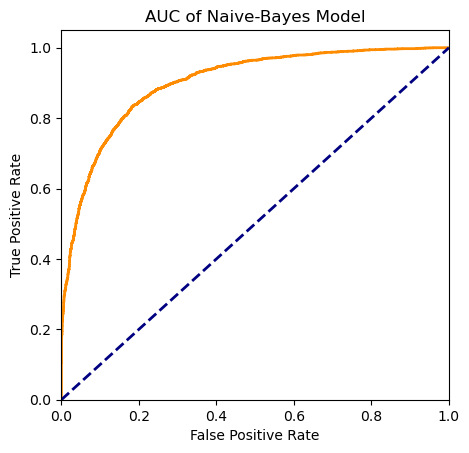

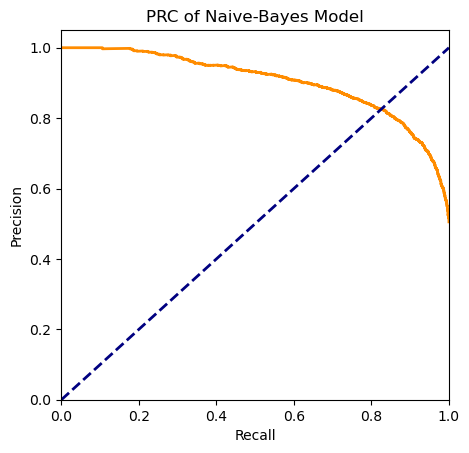

In [4]:
# default tokenizer 
auc_score, prc_score = create_model(x_train, y_train, x_test, y_test, \
            model_type='nb',  min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)


 AUC:88.36%
 PRC:88.72%

              precision    recall  f1-score   support

           0       0.69      0.93      0.79      2968
           1       0.90      0.59      0.71      3032

    accuracy                           0.76      6000
   macro avg       0.79      0.76      0.75      6000
weighted avg       0.79      0.76      0.75      6000



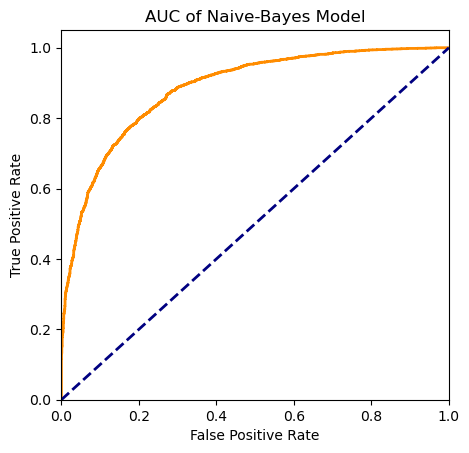

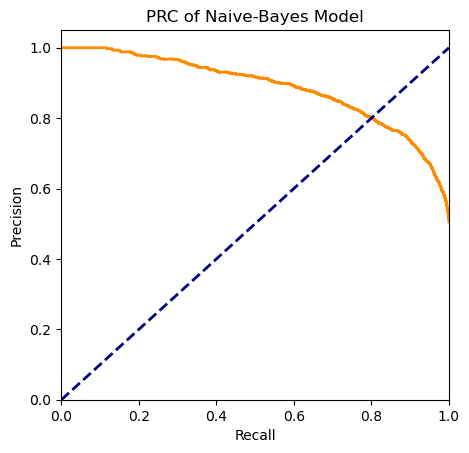

In [5]:
# custom tokenizer 
auc_score, prc_score = create_model(x_train, y_train, x_test, y_test, \
            model_type='nb',  min_df = 1, stop_words='english', \
                                    print_result=True, algorithm_para=1.0)


### Linear SVM

Using Linear SVM as a classifier, specifying stopwords reduced precision and recall for both classes.Using Naive-Bayes as a classifier, specifying stopwords reduced precision for both classes, with -3% p(0) | -2% p(1), -2% r(0) | -4% r(1). This indicates that removing stopwords further increases the complexity of the decision surface in the optimal hyperplane found by the model. This could be caused by the data being too complex for the model, or the model not generalizing well to the data/dividing up nonlinear boundaries too strictly. Since SVM showed an even larger decrease in peformance that NB, this confirms that removing stopwords is not the most effective feature engineering technique for classifying the given data.

 AUC:96.89%
 PRC:97.07%

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2968
           1       0.92      0.89      0.91      3032

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



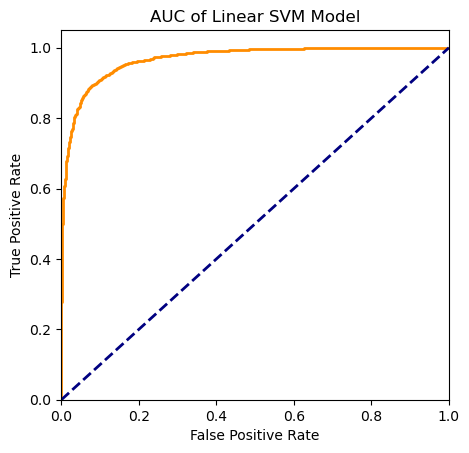

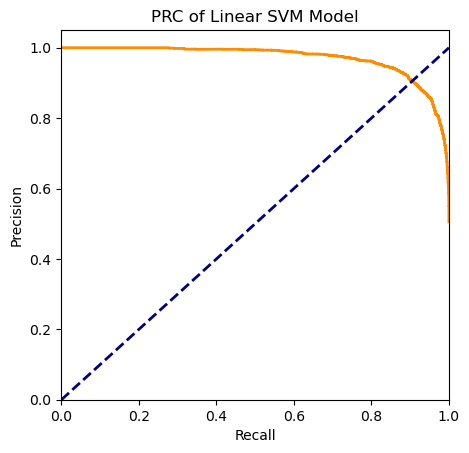

In [6]:
# default tokenizer
auc_score, prc_score = create_model(x_train, y_train, x_test, y_test, \
            model_type='svm',  min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)


 AUC:95.29%
 PRC:95.67%

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      2968
           1       0.90      0.85      0.88      3032

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



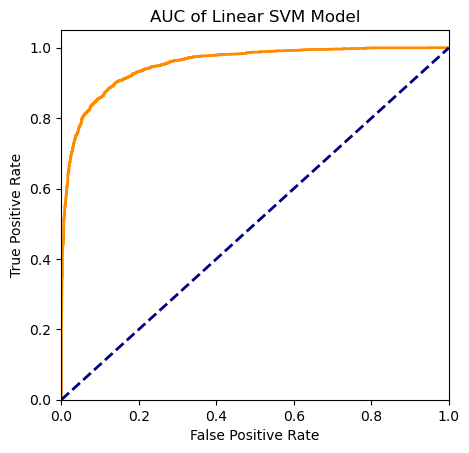

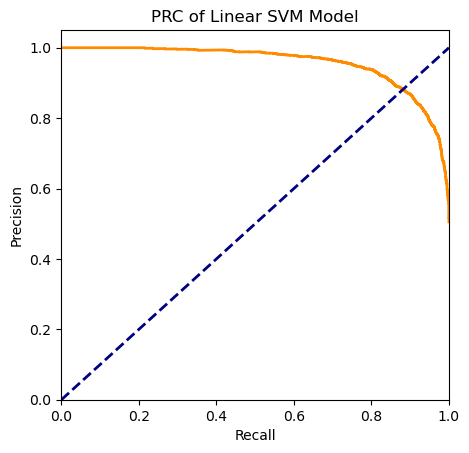

In [7]:
# custom tokenizer 
auc_score, prc_score = create_model(x_train, y_train, x_test, y_test, \
            model_type='svm',  min_df = 1, stop_words='english', \
                                    print_result=True, algorithm_para=1.0)

### Task 2: Search for best parameters 

From Task 1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters

- Define a function `search_para(docs, y)` where `docs` are training documents and `y` is the ground-truth labels.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and `SVM` classifier 
    - Define the parameter ranges as follow:
        - `stop_words': [None, 'english']`
        - `min_df: [1,2,5]`
        - `C: [0.1,0.5,1]`
    - Set the scoring metric to "f1_macro"
    - Use `GridSearchCV` with `5-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the best parameter values
    
- Call the function `svm_model` defined in Task 1 `with the best parameter values`. You will have to add the best C value to the original function, because you used default settings of the SVM classifier previously. Then please briefly answer the following:
    - Compare with the model in Task 1, how is the performance different?
    - Do you think the new parameter values help classification?

In [8]:
def search_para(docs, y):
    
    # separate into train and test
    x_train, _, y_train, _ = train_test_split(\
                docs, y, test_size=0.3, random_state=0)
    
    metric = 'f1_macro'
    # initialize search params
    params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__min_df': [1,2,5],
    'clf__C': [0.1,0.5,1]
    }
    # create pipeline with vectorizer and classifier
    pipeline = pipeline = Pipeline([
                                     ("tfidf", TfidfVectorizer()),  
                                     ("clf", svm.LinearSVC())
                                   ])

    grid = GridSearchCV(pipeline, param_grid=params, scoring = metric , cv=5, n_jobs = -1)
    # return optimal params
    return grid.fit(x_train,y_train)
    

In [9]:
grid = search_para(data["text"], data["label"])

for param_name in grid.best_params_:
    print("{0}:\t{1}".format(param_name,grid.best_params_[param_name]))

print("best f1 score: {:.3f}".format(grid.best_score_))


clf__C:	0.5
tfidf__min_df:	5
tfidf__stop_words:	None
best f1 score: 0.911


 AUC:97.25%
 PRC:97.45%

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2968
           1       0.92      0.91      0.91      3032

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



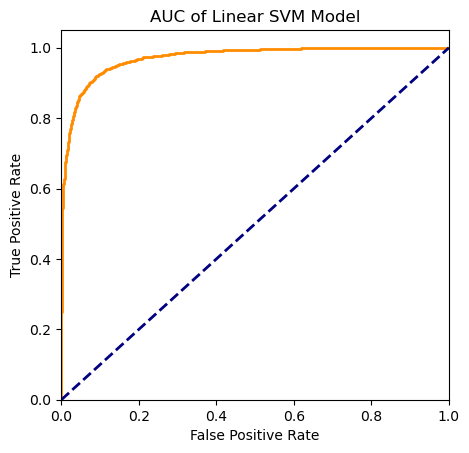

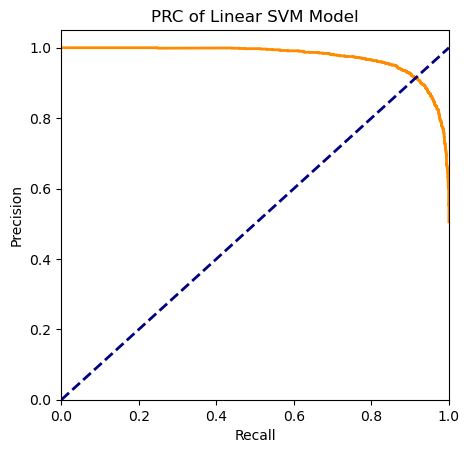

In [10]:
min_df = grid.best_params_['tfidf__min_df']
stop_words = grid.best_params_['tfidf__stop_words']
C = grid.best_params_['clf__C']

auc_score, prc_score = create_model(x_train, y_train, x_test, y_test, \
                                    model_type='svm', min_df = min_df, stop_words=stop_words, \
                                    print_result=True, algorithm_para=C)

###  Compare with the model in Task 1, how is the performance different? 

In task 1, the best performance for SVM was with  stop_words=None, and defaults min_df=1, C=1.0, with overall results:

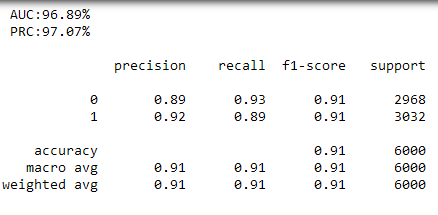

In comparision, grid search found the optimal hyperparameters as C=0.5, min_df=5, stop_words=None, with overall results:

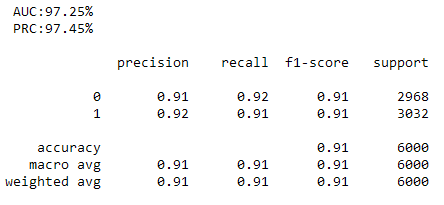

While the overall f1-scores were the same for both cases, the grid search params increased precision for "0" and recall for "1", with a slight drop of 1 point for "0" recall. This shows the new parameters allow the model to more accurately predict elements in class "0", and is more sensitive to elements in class "1", but slightly less sensitive to class "0". While the model's ability to detect "0" classes, it made more correct classifications overall and performs almost the same in precision vs. recall regardless of the class, while maintaining the same f1-scores as task 1 and resulting in higher AUC and PRC scores. 

### Do you think the new parameter values help classification?
Assuming:

precision = p(C) = TP/(TP + FP) --> when the model predicts class C, it is correct p% of the time (accuracy)  
recall = r(C) = TP/(TP + FN) --> the model correctly identifies class C p% of the time (sensitivity)  

I think the new parameter values helped with classification by increasing precision for "0" and recall for "1", resulting in the same f1-score but higher AUC and PRC values.  
  
For class "0", this corresponds to a higher proportion of true positive classifications of "0" out of all elements classified as "0". However, recall for "0" slightly decreased and was still larger than precision for "0", so there were more false positive than false negative guesses for "0". Higher accuracy, slightly slower sensitivity.  
  
For class "1", precision stayed the same, meaning the proportion of true positive to true negative guesses didnt change. Recall increased by 2 points, so there were fewer false negative classifications of "1" elements as "0". Equal accuracy, higher sensitivity.

## Task 3. How many training samples are enough? 

This task is to help you understand the impact of training and testing sample size on classifier performance. 

- Define a function `sample_size_impact(docs,y)` with the input as defined above. 
    
    
- This function does the following:
    - Iterate the percentage of testing data in train/test split, from 0.9 to 0.1 with a step of 0.1. In this case, you start with 10% of training data and 90% of testing data, and end up with 90% of training data and 10% of testing data. 
    - In each round, call the `create_model` function with `model_type='svm'` and  `model_type='nb'` and `stop_words='english'`. Keep other parameters as default. Record the AUC score of each model type and the sample size.
    - After all the interations, for each model type, plot a line chart show the relationship between sample size and the AUC score. 
    - This function has no return.
    
    
- Write your analysis on the following:
    - How training and testing sample size affects each classifier’s performance? 
    - How is performance of SVM classifier compared with Naïve Bayes classifier?

In [11]:
def call_models(print_result = True):
    # choose whether to print result or not
    nb_auc, _ = create_model(x_train, y_train, x_test, y_test, \
            model_type='nb',  min_df = 1, stop_words='english', print_result=print_result, algorithm_para=1.0)
    
    svm_auc, _ = create_model(x_train, y_train, x_test, y_test, \
        model_type='svm',  min_df = 1, stop_words='english', print_result=print_result, algorithm_para=1.0)
    
    return nb_auc, svm_auc

In [29]:
# Show the impact of sample size

def sample_size_impact(docs, y):  
    train_size = list(range(1,10))
    train_size.reverse()
    train_size = [i/10 for i in train_size]
    
    nb_performance = []
    svm_performance = []

    print_r = False
    for size in train_size:
        # if show results, print sample size
        if print_r == True:
            print('Training sample size: ',(10-size*10)/10)
            
        # separate into train and test
        x_train, x_test, y_train, y_test = train_test_split(\
                    data["text"], data["label"], test_size= size, random_state=0)
        
        # choose whether to print result or not
        nb_auc, _ = create_model(x_train, y_train, x_test, y_test, \
        model_type='nb',  min_df = 1, stop_words='english', print_result=print_r, algorithm_para=1.0)

        svm_auc, _ = create_model(x_train, y_train, x_test, y_test, \
        model_type='svm',  min_df = 1, stop_words='english', print_result=print_r, algorithm_para=1.0)
        
        nb_performance.append(nb_auc)
        svm_performance.append(svm_auc)
    
    
    plt.figure().set_figwidth(5);
    plt.plot(train_size, nb_performance, color='darkorange', lw=2, label = 'NB');
    plt.plot(train_size, svm_performance, color='navy', lw=2, label = 'SVM');
    plt.axis([1,0, 0.8, 1]);
    plt.xlabel('testing sample percentage');
    plt.ylabel('AUC');
    plt.legend();
    plt.show();

Training sample size:  0.1
 AUC:80.95%
 PRC:82.11%

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      8996
           1       0.78      0.63      0.70      9004

    accuracy                           0.73     18000
   macro avg       0.74      0.73      0.72     18000
weighted avg       0.74      0.73      0.72     18000



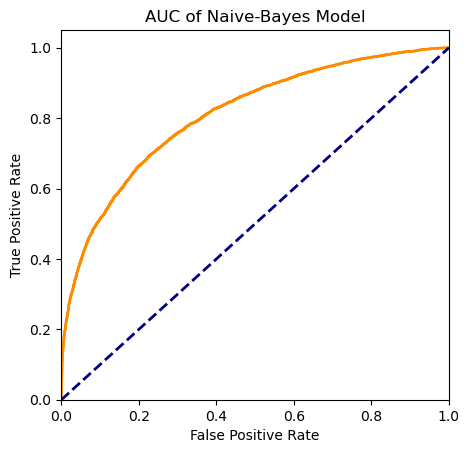

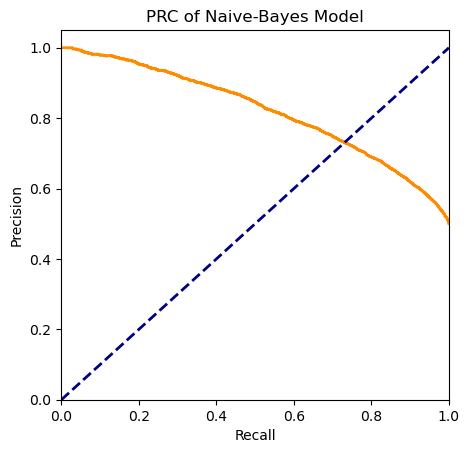

 AUC:87.89%
 PRC:88.46%

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      8996
           1       0.83      0.75      0.79      9004

    accuracy                           0.80     18000
   macro avg       0.80      0.80      0.80     18000
weighted avg       0.80      0.80      0.80     18000



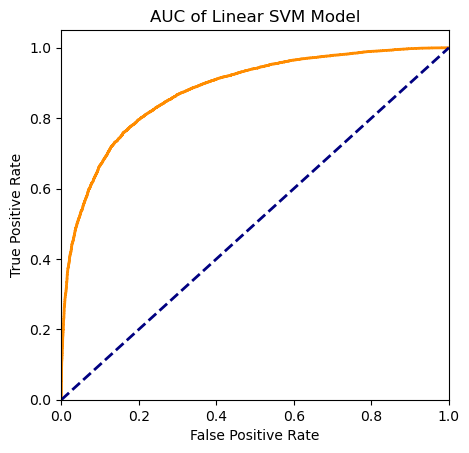

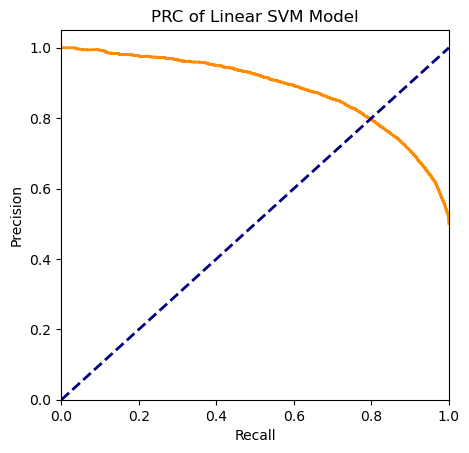

Training sample size:  0.2
 AUC:84.71%
 PRC:85.27%

              precision    recall  f1-score   support

           0       0.67      0.91      0.77      7966
           1       0.86      0.57      0.68      8034

    accuracy                           0.74     16000
   macro avg       0.77      0.74      0.73     16000
weighted avg       0.77      0.74      0.73     16000



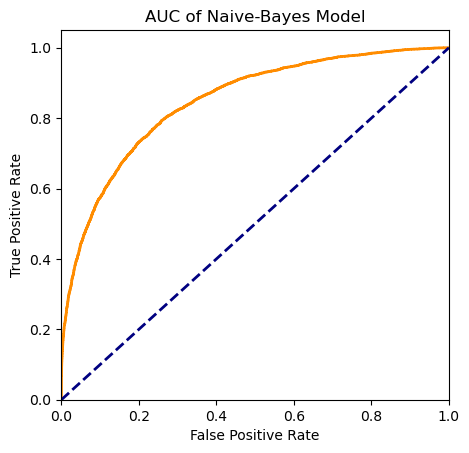

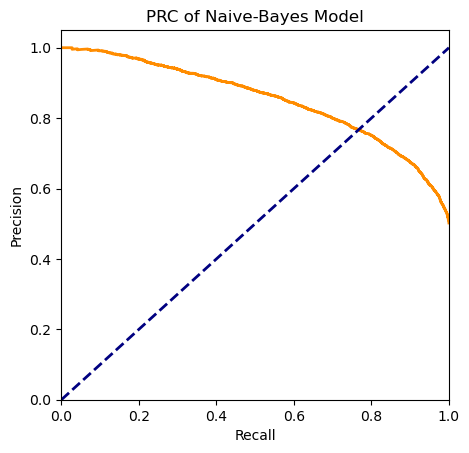

 AUC:91.58%
 PRC:91.99%

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      7966
           1       0.87      0.79      0.83      8034

    accuracy                           0.83     16000
   macro avg       0.84      0.83      0.83     16000
weighted avg       0.84      0.83      0.83     16000



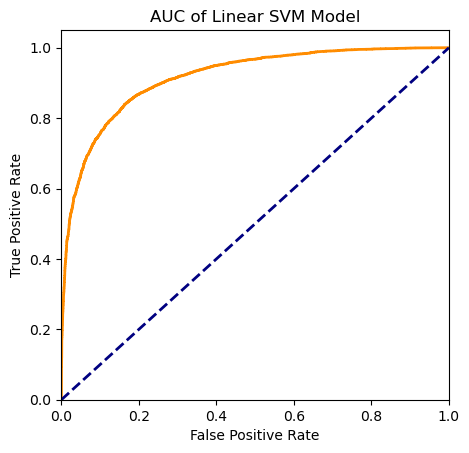

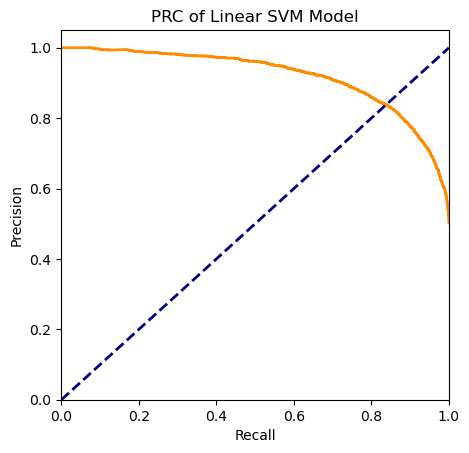

Training sample size:  0.3
 AUC:85.35%
 PRC:85.82%

              precision    recall  f1-score   support

           0       0.69      0.90      0.78      6985
           1       0.85      0.61      0.71      7015

    accuracy                           0.75     14000
   macro avg       0.77      0.75      0.74     14000
weighted avg       0.77      0.75      0.74     14000



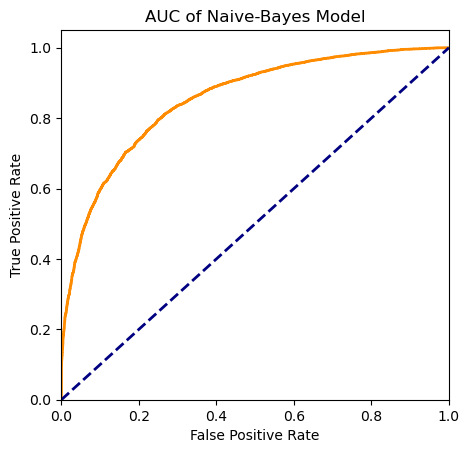

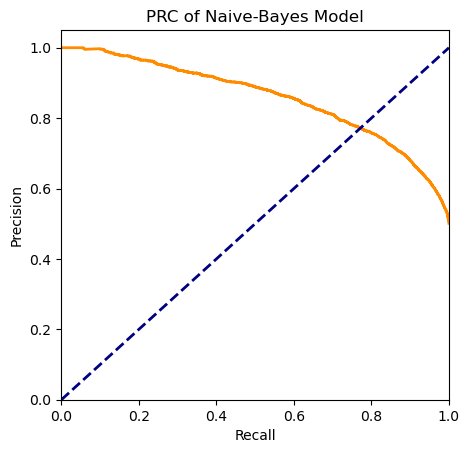

 AUC:93.02%
 PRC:93.41%

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      6985
           1       0.88      0.81      0.85      7015

    accuracy                           0.85     14000
   macro avg       0.85      0.85      0.85     14000
weighted avg       0.85      0.85      0.85     14000



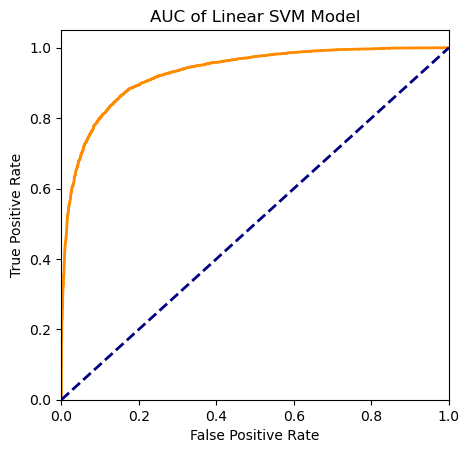

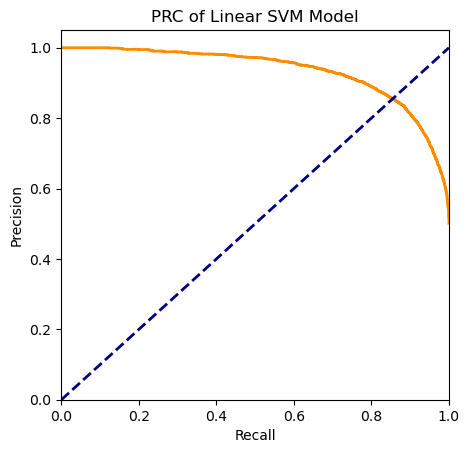

Training sample size:  0.4
 AUC:86.96%
 PRC:87.46%

              precision    recall  f1-score   support

           0       0.68      0.92      0.78      5959
           1       0.88      0.57      0.69      6041

    accuracy                           0.75     12000
   macro avg       0.78      0.75      0.74     12000
weighted avg       0.78      0.75      0.74     12000



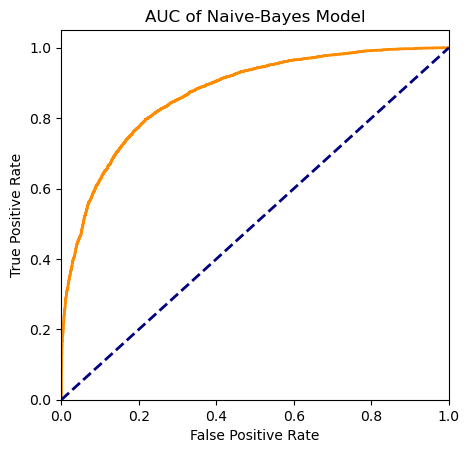

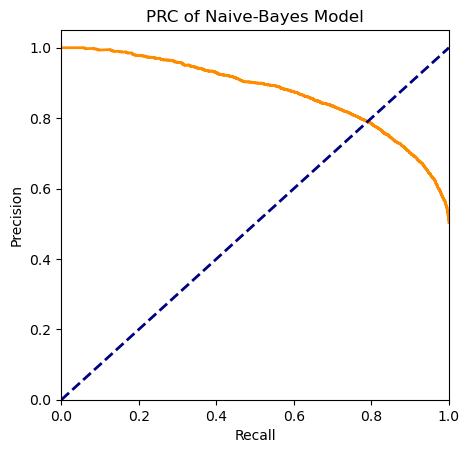

 AUC:93.95%
 PRC:94.27%

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      5959
           1       0.89      0.83      0.86      6041

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



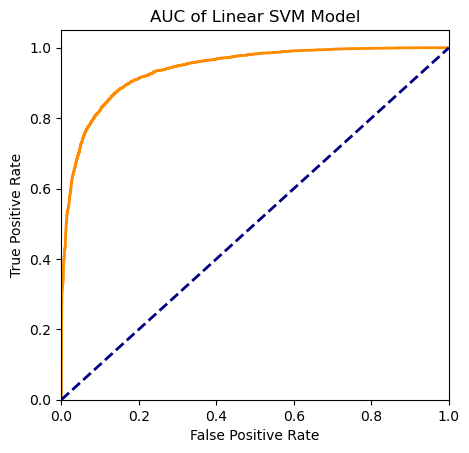

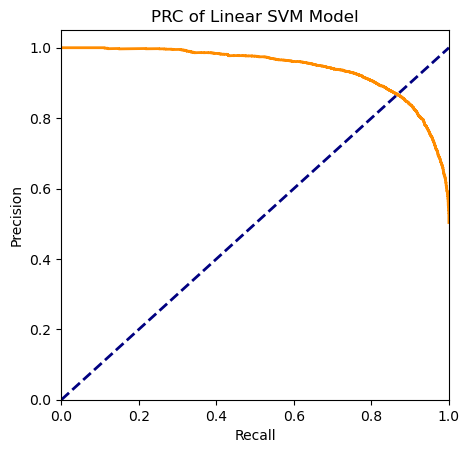

Training sample size:  0.5
 AUC:87.09%
 PRC:87.58%

              precision    recall  f1-score   support

           0       0.69      0.92      0.79      4976
           1       0.88      0.59      0.71      5024

    accuracy                           0.75     10000
   macro avg       0.78      0.76      0.75     10000
weighted avg       0.78      0.75      0.75     10000



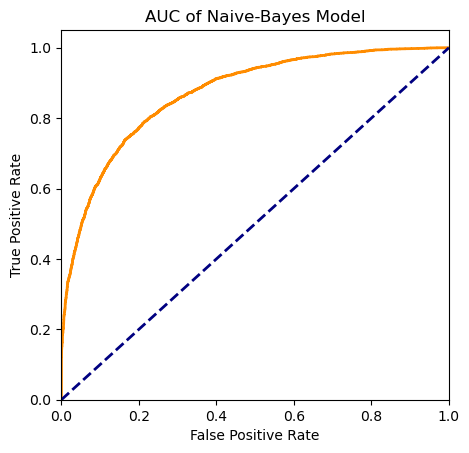

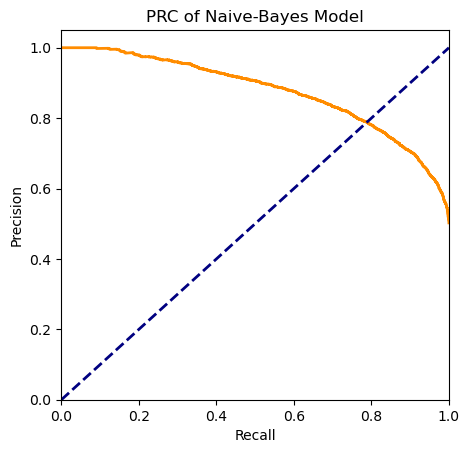

 AUC:94.56%
 PRC:94.85%

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4976
           1       0.90      0.84      0.87      5024

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



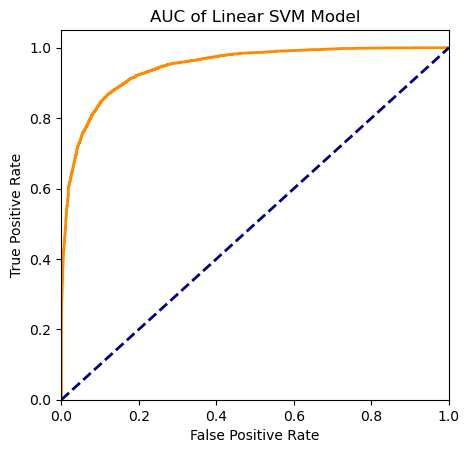

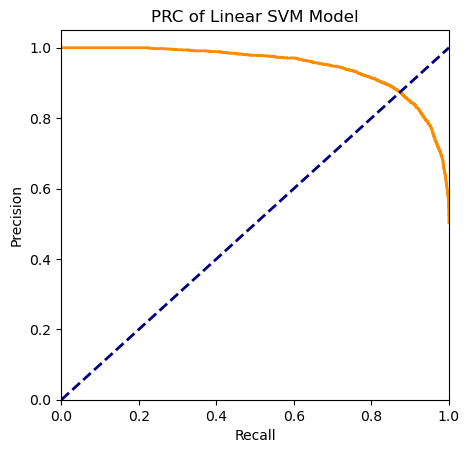

Training sample size:  0.6
 AUC:87.96%
 PRC:88.38%

              precision    recall  f1-score   support

           0       0.69      0.92      0.79      3967
           1       0.89      0.59      0.71      4033

    accuracy                           0.76      8000
   macro avg       0.79      0.76      0.75      8000
weighted avg       0.79      0.76      0.75      8000



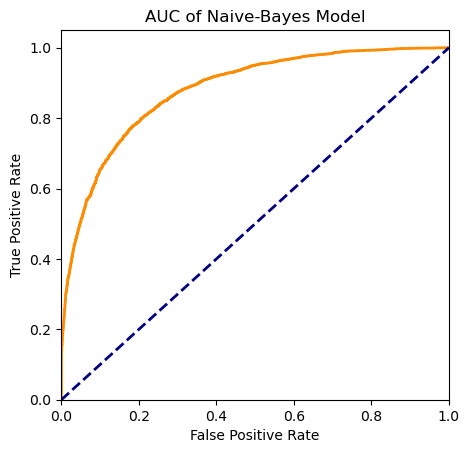

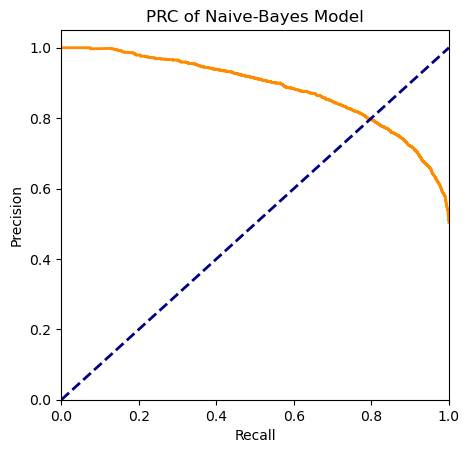

 AUC:95.06%
 PRC:95.42%

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      3967
           1       0.90      0.85      0.87      4033

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



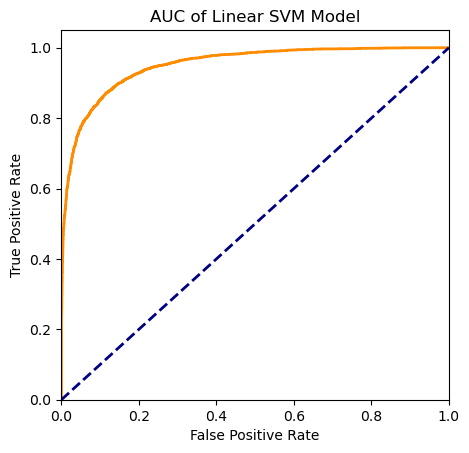

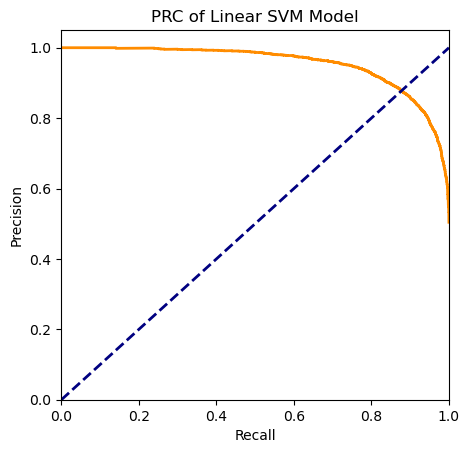

Training sample size:  0.7
 AUC:88.36%
 PRC:88.72%

              precision    recall  f1-score   support

           0       0.69      0.93      0.79      2968
           1       0.90      0.59      0.71      3032

    accuracy                           0.76      6000
   macro avg       0.79      0.76      0.75      6000
weighted avg       0.79      0.76      0.75      6000



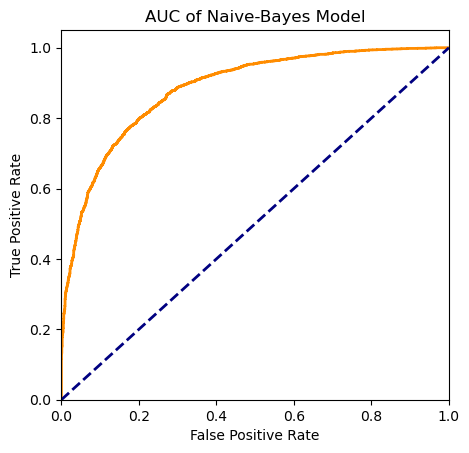

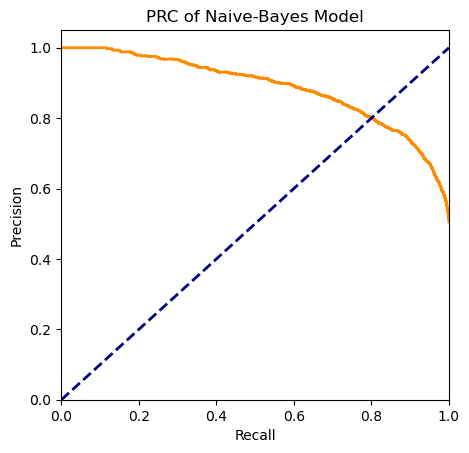

 AUC:95.29%
 PRC:95.67%

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      2968
           1       0.90      0.85      0.88      3032

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



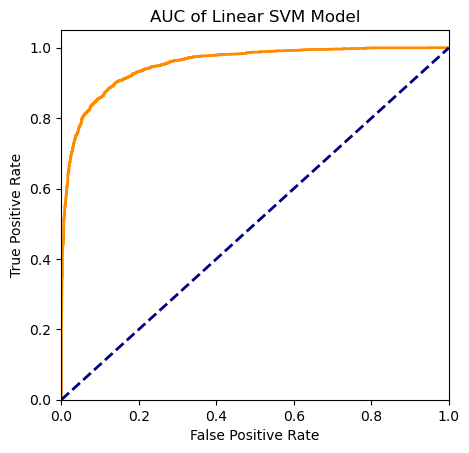

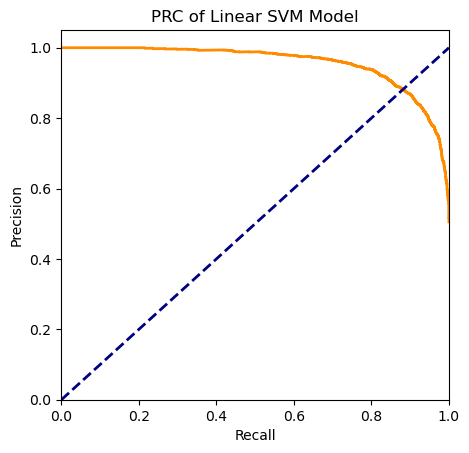

Training sample size:  0.8
 AUC:89.17%
 PRC:89.74%

              precision    recall  f1-score   support

           0       0.69      0.93      0.79      1966
           1       0.90      0.60      0.72      2034

    accuracy                           0.76      4000
   macro avg       0.80      0.76      0.76      4000
weighted avg       0.80      0.76      0.76      4000



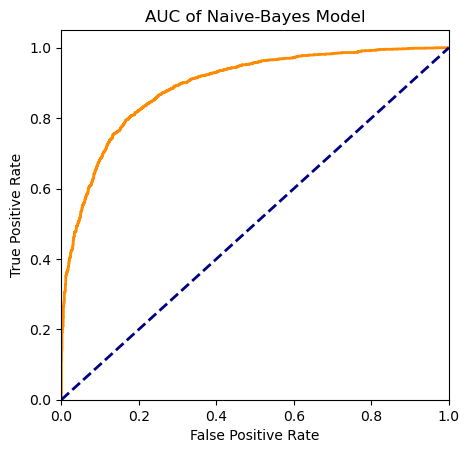

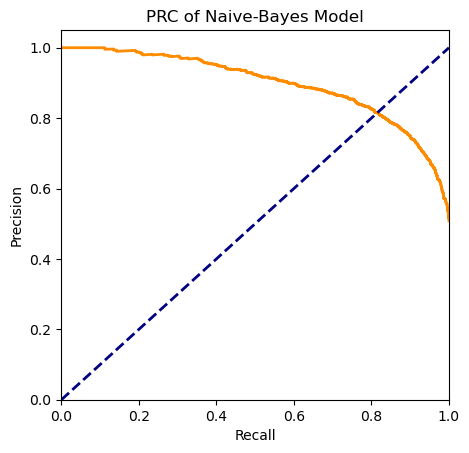

 AUC:95.49%
 PRC:95.95%

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1966
           1       0.91      0.86      0.88      2034

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



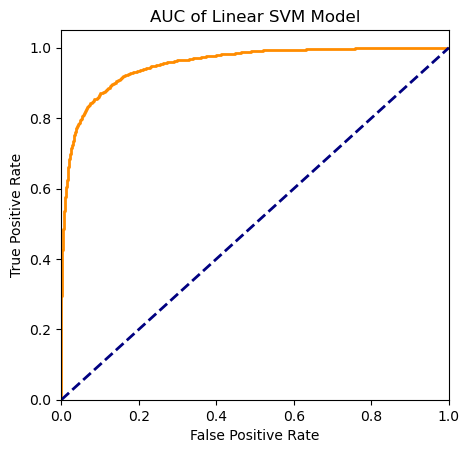

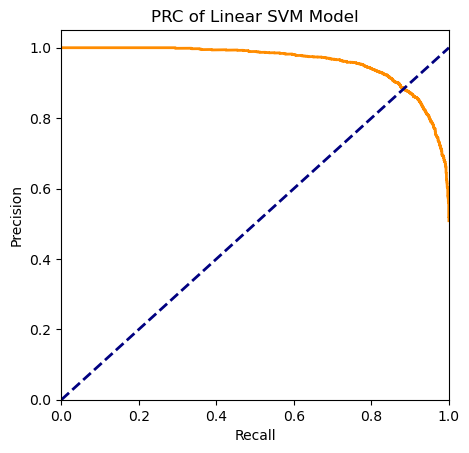

Training sample size:  0.9
 AUC:89.41%
 PRC:89.67%

              precision    recall  f1-score   support

           0       0.69      0.93      0.79       987
           1       0.90      0.60      0.72      1013

    accuracy                           0.76      2000
   macro avg       0.80      0.77      0.76      2000
weighted avg       0.80      0.76      0.76      2000



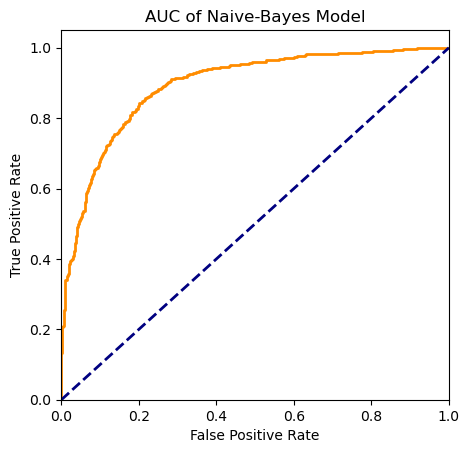

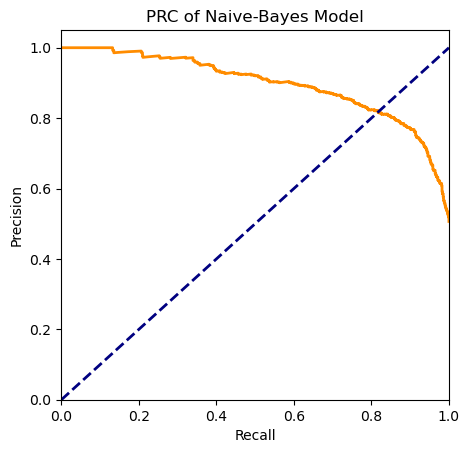

 AUC:95.68%
 PRC:96.12%

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       987
           1       0.92      0.86      0.89      1013

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



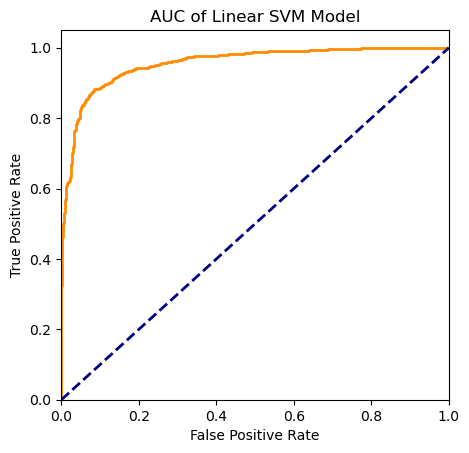

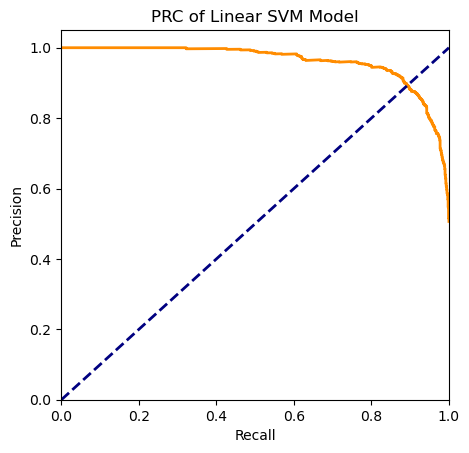

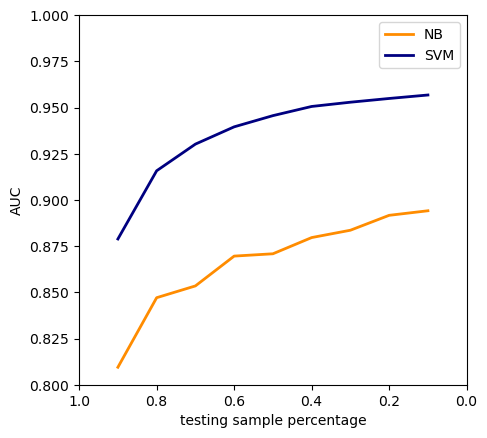

In [28]:
# print every graph; default
sample_size_impact(data["text"],data["label"])

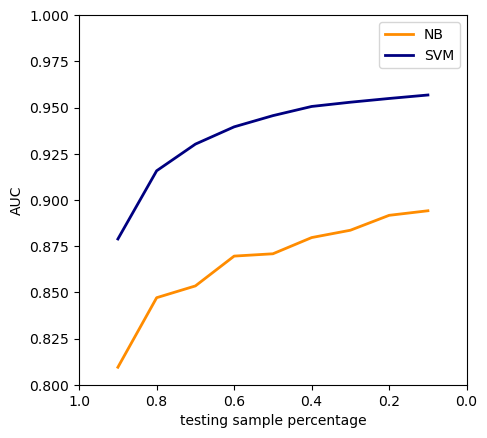

In [30]:
# print only final graph
sample_size_impact(data["text"],data["label"])

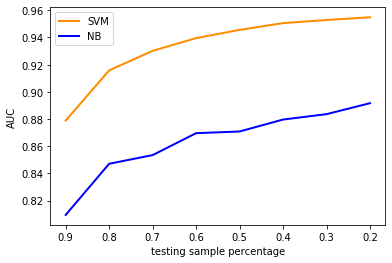

In [126]:
# Test the function


sample_size_impact(data["text"],data["label"])


# Briefly answer the questions

### How training and testing sample size affects each classifier’s performance?

Decreasing the testing sample size and increasing the testing sample size improved the performance for both classifiers. This is because both models can "learn" the features better/generalize new data more accurately with a larger training set. This makes sense with the previous results, as removing stop words decreased performance, indicating more data was needed to fully understand the patterns in the data.

### How is performance of SVM classifier compared with Naïve Bayes classifier?

SVM did especially well, since it can better define where to create and segement boundaries to linearize the data in the feature space the more data points it has. NB is not sensitive to less relevant data due to its assumption of no-condition independence of all features. As the size of the training set increases, NB performance also improves due to having more information to refine its classification rules, but this also increases the complexity of the feature space and introduces more dependence between features. This causes the performance of NB to increase at a slower rate than SVM, as well as a poorer performance overall, suggesting the creation of nonlinearities in the input data. 

## Task 4 (Bonus): How to improve AI generated content detection?

- Can you tune other parameters of TfidfVectorizer or SVM model to further improve the classification performance? Try to beat the model you get in Task 2!

In [38]:
def search_params(docs, y, params):
    # separate into train and test
    x_train, _, y_train, _ = train_test_split(\
                docs, y, test_size=0.3, random_state=0)
    
    metric = 'f1_macro'
    # create pipeline with vectorizer and classifier
    pipeline = pipeline = Pipeline([
                                     ("tfidf", TfidfVectorizer()),  
                                     ("clf", svm.SVC())
                                   ])

    grid = GridSearchCV(pipeline, param_grid=params, scoring = metric , cv=5, n_jobs = -1)
    # return optimal params
    return grid.fit(x_train,y_train)

In [39]:
def search_params(docs, y, params):
    # separate into train and test
    x_train, _, y_train, _ = train_test_split(\
                docs, y, test_size=0.3, random_state=0)
    
    metric = 'f1_macro'
    # create pipeline with vectorizer and classifier
    pipeline = pipeline = Pipeline([
                                     ("tfidf", TfidfVectorizer()),  
                                     ("clf", svm.LinearSVC())
                                   ])

    grid = GridSearchCV(pipeline, param_grid=params, scoring = metric , cv=5, n_jobs = -1)
    # return optimal params
    return grid.fit(x_train,y_train)

In [44]:
params = {
            'tfidf__stop_words': [None,"english"],
            'tfidf__min_df': [1,3,5],
            'clf__C': [0.7,0.8,0.9],
            'clf__tol': [0.2,0.1,1e-2,1e-4],
            'clf__dual': [True,False]
        }

grid = search_params(data["text"], data["label"], params)

for param_name in grid.best_params_:
    print("{0}:\t{1}".format(param_name,grid.best_params_[param_name]))

print("best f1 score: {:.3f}".format(grid.best_score_))

clf__C:	0.8
clf__dual:	False
clf__tol:	0.2
tfidf__min_df:	5
tfidf__stop_words:	None
best f1 score: 0.912


In [54]:
# make function only SVM and add extra parameters

def create_SVM_model(x_train, y_train, x_test, y_test, min_df = 1,stop_words=None, 
                 print_result = True, algorithm_para=para):
    # separate SVM hyperparams
    C, dual, tol = para
    # initialize the TfidfVectorizer without any parameters
    vec = TfidfVectorizer(stop_words=stop_words, min_df=min_df) 

    # choose classification model and add hyperparams
    model, model_name = svm.LinearSVC(C=C,dual=dual,tol=tol), 'Linear SVM Model'

    # fit vectorizer using x_train and vectorize training data
    x_train = vec.fit_transform(x_train)
    x_test = vec.transform(x_test)
    # fit classifier model with training data
    model.fit(x_train, y_train)
    
    # predict test set output and get probability of guessing each class
    bin_preds = model.predict(x_test)
    pred_scores = model.decision_function(x_test)
    
    # get ROC curve using tpr/fpr and calculate AUC score
    fpr, tpr, _ = roc_curve(y_test, pred_scores)
    auc_score = roc_auc_score(y_test, pred_scores)
    
    # get PRC curve using precision/recall and calculate PRC score
    precision, recall, _ = precision_recall_curve(y_test, pred_scores)
    prc_score = auc(recall, precision)
    
    if print_result: 
        # print curve scores
        print(' AUC:{:.2%}\n'.format(auc_score),'PRC:{:.2%}\n'.format(prc_score))
        # print classification report
        print( classification_report(y_test, bin_preds, target_names=['0','1']) )
        # show curve plots
        show_plots({'x':fpr, 
                    'y':tpr, 
                    'curve':'auc', 
                    'title': 'AUC of '+ model_name})
        show_plots({'x':recall, 
                    'y':precision, 
                    'curve':'prc', 
                    'title': 'PRC of '+ model_name})
    
    return auc_score, prc_score

 AUC:97.27%
 PRC:97.47%

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2968
           1       0.92      0.91      0.91      3032

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



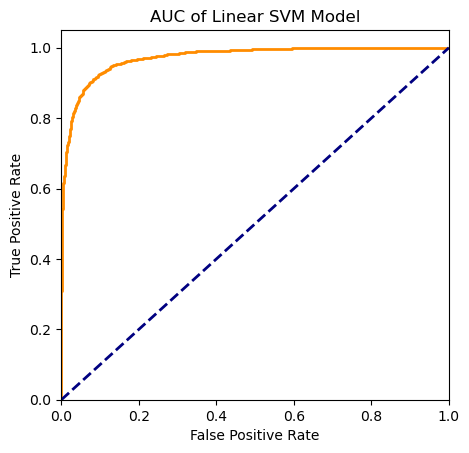

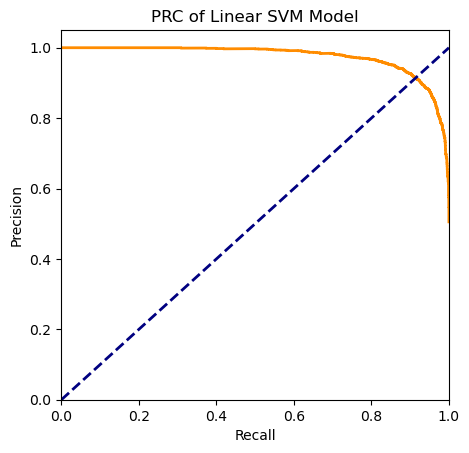

In [55]:
min_df = grid.best_params_['tfidf__min_df']
stop_words = grid.best_params_['tfidf__stop_words']
para = [grid.best_params_['clf__C'], grid.best_params_['clf__dual'], grid.best_params_['clf__tol']]

auc_score, prc_score = create_SVM_model(x_train, y_train, x_test, y_test, min_df = min_df, stop_words=stop_words, \
                                    print_result=True, algorithm_para=para)

### Task 2:
Grid search parameters:
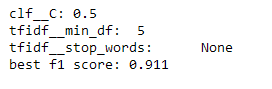
Results:
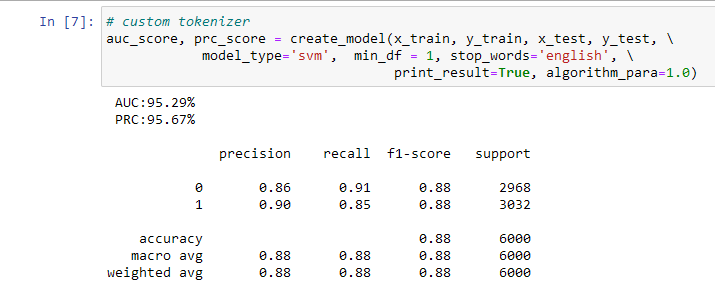

### Task 4:
Added SVM parameters for "dual" and "tol". From documentation:
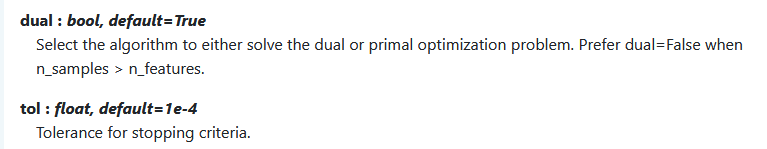
Grid search parameters:
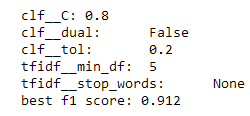
Results:
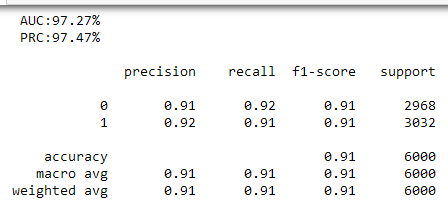

### Results
class "0": p+5, r+1  
class "1": p+2, r+6  

Big improvement to recall for "1" and precision for "0". The model performed better using the primal optimizer instead of dual, as well as with a larger/less strict tolerance. This indicates the original SVM model was overly complex for fitting the tokenized data.